# APRENDIZAJE PROFUNDO
# Optimización - Regularización
# 2024-1
# Laboratorio 1/3
# Presentado por:
 - Juan Pablo Daza Pereira
 - Juan Sebastian Camargo Sanchez

# ---------------------------------------------------------------------------------------------------------------------

# **InteractiveShell**

In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from platform import python_version
'Python ' + python_version()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------------------------------------------------

# **SOFTWARE REDES NEURONALES. S-RNN-IAAP. Primera, Segunda y Tercera Extensión.**


In [40]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
#------------------------------
def initialize_parameters(layers):
    red = {}
    for i in range(1, len(layers)):
        auxW = np.random.randn(layers[i], layers[i-1]) * 0.01
        auxB = np.zeros((layers[i], 1))
        red["W" + str(i)] = auxW
        red["b" + str(i)] = auxB
    return red
#------------------------------
def forward_step(A_1, W, b, g):
    zeta = W @ A_1 + b
    zeta = zeta.astype(np.float128)

    if g == "Sigmoid":
        A = 1 / (1 + np.exp(-zeta))
    elif g == "Relu":
        A = np.maximum(0, zeta)
    elif g == "Softmax":
        exp_x = np.exp(zeta - np.max(zeta))
        A = exp_x / np.sum(exp_x, axis=0)
    elif g == "Tanh":
        A = (np.exp(zeta) - np.exp(-zeta)) / (np.exp(zeta) + np.exp(-zeta))
    else:
        A = zeta

    return A, np.array([A_1, W, A, g], dtype=object)
#------------------------------
def forward(X, parameters, activations):
    A_1 = X
    caches = []

    for i in range(1, int(len(parameters) / 2) + 1):
        W = parameters["W" + str(i)]
        b = parameters["b" + str(i)]

        A, cache = forward_step(A_1, W, b, activations[i - 1])
        caches.append(cache)
        A_1 = A

    return A, caches
#------------------------------
def predict(X, parameters, activations):
    A = X
    caches = []
    L = len(parameters) // 2

    for l in range(1, L + 1):
        A_prev = A
        W = parameters[f'W{l}']
        b = parameters[f'b{l}']
        A, cache = forward_step(A_prev, W, b, activations[l - 1])
        caches.append(cache)

    return A, caches

#------------------------------
#def accuracy(X, Y, parameters, activations):
    #AL = predict(X, parameters, activations)
    #predictions = np.where(AL > 0.6, 1, 0)
    #accuracy = np.mean(predictions == Y)
    #return accuracy
#------------------------------
def accuracy(X, Y, parameters, activations):
    AL = predict(X, parameters, activations)
    print("Predictions:", AL)
    predictions = np.argmax(AL, axis=0)
    print("Predicted labels:", predictions)
    true_labels = np.argmax(Y, axis=0) #Puse esto para poder promediar cada etiqueta que va surgiendo para poder llegar a un valor aproximado
    print("True labels:", true_labels)
    accuracy = np.mean(predictions == true_labels)
    print("Accuracy:", accuracy)
    return accuracy
#------------------------------
def mse(X, Y, parameters, activations):
    AL = predict(X, parameters, activations)
    mseResult = np.mean(np.square(AL - Y))
    mseResult = np.squeeze(mseResult)
    return mseResult
#------------------------------
def cost(Yp, Y, cost):
    Yp = np.maximum(Yp, sys.float_info.min)
    m = Y.shape[1]
    if cost == "Binary":
        cost = -1/m * np.sum(Y * np.log(Yp + sys.float_info.epsilon) + (1 - Y) * np.log(1 - Yp + sys.float_info.epsilon))
    elif cost == "Cathegory":
        cost = -np.mean(np.sum(Y * np.log(Yp + sys.float_info.epsilon), axis=0))
    else:
        cost = np.mean(np.square(Yp - Y))
    return cost
#------------------------------
def backward_step(dA, cache, activation):
    A_prev, W, A, _ = cache
    m = A_prev.shape[1]

    if activation == "Sigmoid":
        dZ = dA * A * (1 - A)
    elif activation == "Relu":
        dZ = np.array(dA, copy=True)
        dZ[A <= 0] = 0
    else:
        dZ = dA

    dA_prev = np.dot(W.T, dZ)
    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

    return dA_prev, dW, db
#------------------------------
def backward(AL, Y, caches, activations, cost_type):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    if cost_type == "Binary":
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    elif cost_type == "Category":
        dAL = - (np.divide(Y, AL))
    else:
        dAL = 2 * (AL - Y)

    for l in reversed(range(L)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_step(dAL, current_cache, activations[l])
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        dAL = dA_prev_temp

    return grads
#------------------------------
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters
#------------------------------
def train(X, Y, layers, activations, funcost, learning_rate, iterations, print_interval, graph):

    parameters = initialize_parameters(layers)

    costs = []

    for i in range(iterations):
        AL, caches = forward(X, parameters, activations)

        cost_value = cost(AL, Y, funcost)
        costs.append(cost_value)

        grads = backward(AL, Y, caches, activations, cost)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_interval > 0 and i % print_interval == 0:
            print(f"Costo después de la iteración {i}: {cost_value}")

    if graph:
        plt.plot(costs)
        plt.xlabel("Iteraciones")
        plt.ylabel("Costo")
        plt.title("Función de costo sobre iteraciones")
        plt.show()

    return parameters
#------------------------------
# PARTE B. S-RNN-IAAP. Segunda extensión.
def trainO(X, Y, layers, activations, funcost, learning_rate, batches, epochs, print_interval, graph):
    parameters = initialize_parameters(layers)
    costs = []
    learning_rate_decay = learning_rate[0]
    decay_rate = learning_rate[1]
    num_batches = X.shape[1] // batches

    for epoch in range(epochs):
        epoch_cost = 0

        for batch in range(num_batches):
            start = batch * batches
            end = min(start + batches, X.shape[1])
            X_batch = X[:, start:end]
            Y_batch = Y[:, start:end]

            AL, caches = forward(X_batch, parameters, activations)
            batch_cost = cost(AL, Y_batch, funcost)

            grads = backward(AL, Y_batch, caches, activations, cost)
            parameters = update_parameters(parameters, grads, learning_rate[0])

            epoch_cost += batch_cost

            if print_interval > 0 and batch % print_interval == 0:
                print(f"Costo después del mini-lote {batch} en la época {epoch}: {batch_cost}")

        epoch_cost /= num_batches
        costs.append(epoch_cost)

        if print_interval > 0 and epoch % print_interval == 0:
            print(f"Costo después de la época {epoch}: {epoch_cost}")

        print(f"Tasa de aprendizaje en la época {epoch}: {learning_rate[0]}")

        new_learning_rate = learning_rate_decay / (1 + decay_rate * epoch)
        learning_rate[0] = new_learning_rate

    if graph:
        plt.plot(costs)
        plt.xlabel("Épocas")
        plt.ylabel("Costo")
        plt.title("Función de costo sobre épocas")
        plt.show()

    return parameters
#------------------------------
# PARTE C. S-RNN-IAAP. Tercera extensión.
def trainOR(X, Y, layers, activations, funcost, learning_rate, batches, epochs, Xearly, Yearly, patience, print_interval, graph):
    parameters = initialize_parameters(layers)
    costs = []
    learning_rate_decay = learning_rate[0]
    decay_rate = learning_rate[1]
    num_batches = X.shape[1] // batches
    best_cost = float('inf')
    patience_counter = 0
    best_parameters = None

    for epoch in range(epochs):
        epoch_cost = 0

        for batch in range(num_batches):
            start = batch * batches
            end = min(start + batches, X.shape[1])
            X_batch = X[:, start:end]
            Y_batch = Y[:, start:end]

            AL, caches = forward(X_batch, parameters, activations)
            batch_cost = cost(AL, Y_batch, funcost)

            grads = backward(AL, Y_batch, caches, activations, cost)
            parameters = update_parameters(parameters, grads, learning_rate[0])

            epoch_cost += batch_cost

            if print_interval > 0 and batch % print_interval == 0:
                print(f"Costo después del mini-lote {batch} en la época {epoch}: {batch_cost}")

        epoch_cost /= num_batches
        costs.append(epoch_cost)

        if print_interval > 0 and epoch % print_interval == 0:
            print(f"Costo después de la época {epoch}: {epoch_cost}")

        print(f"Tasa de aprendizaje en la época {epoch}: {learning_rate[0]}")

        new_learning_rate = learning_rate_decay / (1 + decay_rate * epoch)
        learning_rate[0] = new_learning_rate

        early_stop_cost = mse(Xearly, Yearly, parameters, activations)
        if early_stop_cost < best_cost:
            best_cost = early_stop_cost
            best_parameters = parameters
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Detención temprana: se ha superado el límite de paciencia.")
            break

    if graph:
        plt.plot(costs)
        plt.xlabel("Épocas")
        plt.ylabel("Costo")
        plt.title("Función de costo sobre épocas")
        plt.show()

    return best_parameters


# ---------------------------------------------------------------------------------------------------------------------

# **Forward Pruebas**

In [13]:
'Testing initialize_parameters (DeepLearningSpecializationCoursera)'
'Test # 1'
np.random.seed(1)
parameters = initialize_parameters([3,2,1])
'W1 b1'
parameters['W1']
assert parameters['W1'].shape==(2,3), "W1. Wrong size"
assert np.all(np.isclose(parameters['W1'],
                         [[ 0.01624345, -0.00611756, -0.00528172], [-0.01072969 ,0.00865408, -0.02301539]])), "W1. Wrong values"

parameters['b1']
assert parameters['b1'].shape==(2,1), "b1. Wrong size"
assert np.all(np.isclose(parameters['b1'], [[ 0.], [ 0.]])), "b1. Wrong values"
'W2 b2'
parameters['W2']
assert parameters['W2'].shape==(1,2), "W2. Wrong size"
assert np.all(np.isclose(parameters['W2'], [[ 0.01744812, -0.00761207]])), "W2. Wrong values"
parameters['b2']
assert parameters['b2'].shape==(1,1), "b2. Wrong size"
assert np.all(np.isclose(parameters['b2'], [[ 0.]])), "b2. Wrong values"
'Test # 2'
np.random.seed(3)
parameters = initialize_parameters([5,4,3])
'W1 b1'
parameters['W1']
assert parameters['W1'].shape==(4,5), "W1. Wrong size"
assert np.all(np.isclose(parameters['W1'],
                        [[ 0.01788628,  0.0043651,   0.00096497, -0.01863493, -0.00277388],
 [-0.00354759, -0.00082741, -0.00627001, -0.00043818, -0.00477218],
 [-0.01313865,  0.00884622,  0.00881318,  0.01709573,  0.00050034],
 [-0.00404677, -0.0054536,  -0.01546477,  0.00982367, -0.01101068]])), "W1. Wrong values"

parameters['b1']
assert parameters['b1'].shape==(4,1), "b1. Wrong size"
assert np.all(np.isclose(parameters['b1'], [[ 0.], [ 0.], [ 0.], [ 0.]])), "b1. Wrong values"
'W2 b2'
parameters['W2']
assert parameters['W2'].shape==(3,4), "W2. Wrong size"
assert np.all(np.isclose(parameters['W2'],
                        [[-0.01185047, -0.0020565,   0.01486148,  0.00236716],
 [-0.01023785, -0.00712993,  0.00625245, -0.00160513],
 [-0.00768836, -0.00230031,  0.00745056,  0.01976111]])), "W2. Wrong values"

parameters['b2']
assert parameters['b2'].shape==(3,1), "b2. Wrong size"
assert np.all(np.isclose(parameters['b2'], [[ 0.], [ 0.], [ 0.]])), "b2. Wrong values"

In [14]:
'Testing forward_step (DeepLearningSpecializationCoursera)'
np.random.seed(2)
A_1 = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
'Test # 1: Sigmoid'
A, cache = forward_step(A_1, W, b, "Sigmoid")
'A'
A
assert A.shape==(1,2), "A. Wrong size"
assert np.all(np.isclose(A, [[ 0.96890023, 0.11013289]])), "A. Wrong values"
'Test # 2: Relu'
A, cache = forward_step(A_1, W, b, "Relu")
'A'
A
assert A.shape==(1,2), "A. Wrong size"
assert np.all(np.isclose(A, [[ 3.43896131, 0. ]])), "A. Wrong values"

In [15]:
'Testing forward (DeepLearningSpecializationCoursera)'
np.random.seed(6)
X = np.random.randn(5,4)
parameters={}
parameters['W1'] = np.random.randn(4,5)
parameters['b1'] = np.random.randn(4,1)
parameters['W2'] = np.random.randn(3,4)
parameters['b2'] = np.random.randn(3,1)
parameters['W3'] = np.random.randn(1,3)
parameters['b3'] = np.random.randn(1,1)
activations=['Relu','Relu','Sigmoid']
AL,caches=forward(X, parameters,activations)
'AL'
AL
assert AL.shape==(1,4), "AL. Wrong size"
assert np.all(np.isclose(AL,[[ 0.03921668, 0.70498921, 0.19734387, 0.04728177]])), "AL. Wrong values"
'Caches'
len(caches)
assert len(caches)==3, "Caches. Wrong size"

In [16]:
np.random.seed(6)
X = np.random.randn(5,4)
parameters={}
parameters['W1'] = np.random.randn(4,5)
parameters['b1'] = np.random.randn(4,1)
parameters['W2'] = np.random.randn(3,4)
parameters['b2'] = np.random.randn(3,1)
parameters['W3'] = np.random.randn(1,3)
parameters['b3'] = np.random.randn(1,1)
activations=['Relu','Relu','Sigmoid']
Yp=predict(X, parameters,activations)
'Yp'
Yp
assert Yp.shape==(1,4), "Yp. Wrong size"
assert np.all(np.isclose(Yp,[[ 0.03921668, 0.70498921, 0.19734387, 0.04728177]])), "Yp. Wrong values"

In [17]:
'Testing forward_step (Tanh, Lineal, Softmax)'
np.random.seed(2)
A_1 = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
'Test # 1: Tanh'
A, cache = forward_step(A_1, W, b, "Tanh")
'A'
A
assert A.shape==(1,2), "A. Wrong size"
assert np.all(np.isclose(A, [[ 0.99794156, -0.96982745]])), "A. Wrong values"
'Test # 2: Lineal'
A, cache = forward_step(A_1, W, b, "Lineal")
'A'
A
assert A.shape==(1,2), "A. Wrong size"
assert np.all(np.isclose(A, [[ 3.43896131, -2.08938436]])), "A. Wrong values"
'Test # 3: Softmax'
A, cache = forward_step(A_1, W, b, "Softmax")
'A'
A
assert A.shape==(1,2), "A. Wrong size"
assert np.all(np.isclose(A, [[1., 1.]])), "A. Wrong values"

In [18]:
'Test predict. All activation functions'
np.random.seed(6)
X = np.random.randn(7,4)
parameters={}
parameters['W1'] = np.random.randn(6,7)
parameters['b1'] = np.random.randn(6,1)
parameters['W2'] = np.random.randn(5,6)
parameters['b2'] = np.random.randn(5,1)
parameters['W3'] = np.random.randn(4,5)
parameters['b3'] = np.random.randn(4,1)
parameters['W4'] = np.random.randn(3,4)
parameters['b4'] = np.random.randn(3,1)


activations=['Relu','Tanh','Sigmoid','Sigmoid']
'Test # 1: '+"-".join(activations)
Yp=predict(X, parameters,activations)
'Yp'
Yp
assert Yp.shape==(3,4), "Yp. Wrong size"
assert np.all(np.isclose(Yp,[[0.54934631, 0.5464625 , 0.50429255, 0.54931612],
                            [0.02181788, 0.01892432, 0.05293812, 0.0218333 ],
                            [0.29028351, 0.23641949, 0.25480981, 0.29029499]])), "Yp. Wrong values"

activations=['Relu','Tanh','Sigmoid','Lineal']
'Test # 2: '+"-".join(activations)
Yp=predict(X, parameters,activations)
'Yp'
Yp
assert Yp.shape==(3,4), "Yp. Wrong size"
assert np.all(np.isclose(Yp,[[ 0.19802989,  0.18638773,  0.01717062,  0.19790792],
                             [-3.80296606, -3.94820181, -2.88424072, -3.80224393],
                             [-0.8940075 , -1.17241085, -1.07312207, -0.89395178]])), "Yp. Wrong values"

activations=['Relu','Tanh','Sigmoid','Softmax']
'Test # 3: '+"-".join(activations)
Yp=predict(X, parameters,activations)
'Yp'
Yp
np.sum(Yp,axis=0)
assert Yp.shape==(3,4), "Yp. Wrong size"
assert np.all(np.isclose(Yp,[[0.7386454 , 0.78555919, 0.71887433, 0.73860444],
                             [0.0135153 , 0.0125762 , 0.03949899, 0.01352596],
                             [0.24783931, 0.20186461, 0.24162668, 0.2478696 ]])), "Yp. Wrong values"
assert np.all(np.isclose(np.sum(Yp,axis=0), [1., 1., 1., 1.])), "sum Yp. Wrong values"

# ---------------------------------------------------------------------------------------------------------------------

# **Backward Pruebas**

In [43]:
'Testing cost (DeepLearningSpecializationCoursera)'
Y = np.array([[1, 1, 0]])
Yp = np.array([[.8,.9,0.4]])
cost(Yp,Y,'Binary')
assert np.isclose(cost(Yp,Y,'Binary'),0.2797765635793422), "BinaryCrossEntropy. Wrong values"

'Testing cost (DeepLearningSpecializationCoursera)'

0.27977656357934194

In [41]:
'Testing cost ()'
Y = np.array([[1, 1, 0]])
Yp = np.array([[.8,.9,0.4]])
'Test #1: mse'
cost(Yp,Y,'mse')
assert np.isclose(cost(Yp,Y,'mse'),0.07), "mse. Wrong values"
'Test #2: Cathegory'
Y = np.array([[1, 1, 0]]).T
Yp = np.array([[.8,.9,0.4]]).T
cost(Yp,Y,'Cathegory')
assert np.isclose(cost(Yp,Y,'Cathegory'),0.328504066972036), "class MultiCross Entropy'. Wrong values"

'Testing cost ()'

'Test #1: mse'

0.07

'Test #2: Cathegory'

0.3285040669720355

In [42]:
'Testing backward_step (DeepLearningSpecializationCoursera)'
np.random.seed(2)
dA = np.random.randn(1,2)
A_1 = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
Z = np.random.randn(1,2)

'Test #1: Sigmoid dA_1, dW, db'
A = (1/(1+np.exp(-Z)))
cache = (A_1, W, A, 'Sigmoid')
dA_1, dW, db = backward_step(dA, cache, 'Sigmoid')
dA_1
assert dA_1.shape==(3,2), "A. Wrong size"
assert np.all(np.isclose(dA_1, [[ 0.11017994,  0.01105339],
                             [ 0.09466817,  0.00949723],
                             [-0.05743092, -0.00576154]])), "dA_1. Wrong values"
dW
assert dW.shape==(1,3), "dW. Wrong size"
assert np.all(np.isclose(dW, [[ 0.10266786,  0.09778551, -0.01968084]])), "dW. Wrong values"
db
assert db.shape==(1,1), "db. Wrong size"
assert np.all(np.isclose(db, [[-0.05729622]])), "db. Wrong values"

'Test #2: Relu dA_1, dW, db'
A = np.maximum(Z,0)
cache = (A_1, W, A, 'Relu')
dA_1, dW, db = backward_step(dA, cache, 'Relu')
dA_1
assert dA_1.shape==(3,2), "A. Wrong size"
assert np.all(np.isclose(dA_1, [[ 0.44090989, -0.        ],
                                [ 0.37883606, -0.        ],
                                [-0.2298228,   0.        ]])), "dA_1. Wrong values"
dW
assert dW.shape==(1,3), "dW. Wrong size"
assert np.all(np.isclose(dW, [[ 0.44513824,  0.37371418, -0.10478989]])), "dW. Wrong values"
db
assert db.shape==(1,1), "db. Wrong size"
assert np.all(np.isclose(db, [[-0.20837892]])), "db. Wrong values"

'Testing backward_step (DeepLearningSpecializationCoursera)'

'Test #1: Sigmoid dA_1, dW, db'

array([[ 0.11017994,  0.01105339],
       [ 0.09466817,  0.00949723],
       [-0.05743092, -0.00576154]])

array([[ 0.10266786,  0.09778551, -0.01968084]])

array([[-0.05729622]])

'Test #2: Relu dA_1, dW, db'

array([[ 0.44090989,  0.        ],
       [ 0.37883606,  0.        ],
       [-0.2298228 ,  0.        ]])

array([[ 0.44513824,  0.37371418, -0.10478989]])

array([[-0.20837892]])

In [45]:
'Testing backward(DeepLearningSpecializationCoursera)'
np.random.seed(3)
AL = np.random.randn(1, 2)
Y = np.array([[1, 0]])

A_1_a = np.random.randn(4,2)
W_a = np.random.randn(3,4)
b_a = np.random.randn(3,1)
Z_a = np.random.randn(3,2)
A_a = np.maximum(Z_a,0)
cache_a = (A_1_a, W_a, A_a, 'Relu')

A_1_b = np.random.randn(3,2)
W_b = np.random.randn(1,3)
b_b = np.random.randn(1,1)
Z_b = np.random.randn(1,2)
A_b = (1/(1+np.exp(-Z_b)))
cache_b = (A_1_b, W_b, A_b, 'Sigmoid')

grads = backward(AL, Y, [cache_a, cache_b], ['Relu', 'Sigmoid'], 'Binary')

grads['dW1']

assert grads['dW1'].shape == (3,4), "dW1. Wrong size"
assert np.all(np.isclose(grads['dW1'], [[0.41010002, 0.07807203, 0.13798444, 0.10502167],
                                       [0.,         0.,         0.,         0.,       ],
                                       [0.05283652, 0.01005865, 0.01777766, 0.0135308 ]])), "dW1. Wrong values"
grads['db1']
assert grads['db1'].shape == (3,1), "db1. Wrong size"
assert np.all(np.isclose(grads['db1'],  [[-0.22007063],[ 0.        ],[-0.02835349]])), "db1. Wrong values"


'Testing backward(DeepLearningSpecializationCoursera)'

array([[0.41010002, 0.07807203, 0.13798444, 0.10502167],
       [0.        , 0.        , 0.        , 0.        ],
       [0.05283652, 0.01005865, 0.01777766, 0.0135308 ]])

array([[-0.22007063],
       [ 0.        ],
       [-0.02835349]])

In [44]:
'Testing update_parameters (DeepLearningSpecializationCoursera)'
np.random.seed(2)
parameters={}
parameters['W1'] = np.random.randn(3,4)
parameters['b1'] = np.random.randn(3,1)
parameters['W2'] = np.random.randn(1,3)
parameters['b2'] = np.random.randn(1,1)
np.random.seed(3)
grads={}
grads['dW1'] = np.random.randn(3,4)
grads['db1'] = np.random.randn(3,1)
grads['dW2'] = np.random.randn(1,3)
grads['db2'] = np.random.randn(1,1)

parameters=update_parameters(parameters, grads, 0.1)
parameters['W1']
assert parameters['W1'].shape==(3,4), "W1. Wrong size"
assert np.all(np.isclose(parameters['W1'], [[-0.59562069, -0.09991781, -2.14584584,  1.82662008],
                                            [-1.76569676, -0.80627147,  0.51115557, -1.18258802],
                                            [-1.0535704,  -0.86128581,  0.68284052,  2.20374577]])), "W1. Wrong values"
parameters['b1']
assert parameters['b1'].shape==(3,1), "b1. Wrong size"
assert np.all(np.isclose(parameters['b1'],  [[-0.04659241],[-1.28888275],[ 0.53405496]])), "b1. Wrong values"
parameters['W2']
assert parameters['W2'].shape==(1,3), "W2. Wrong size"
assert np.all(np.isclose(parameters['W2'], [[-0.55569196,  0.0354055,   1.32964895]])), "W2. Wrong values"
parameters['b2']
assert parameters['b2'].shape==(1,1), "b2. Wrong size"
assert np.all(np.isclose(parameters['b2'], [[-0.84610769]])), "b2. Wrong values"


'Testing update_parameters (DeepLearningSpecializationCoursera)'

array([[-0.59562069, -0.09991781, -2.14584584,  1.82662008],
       [-1.76569676, -0.80627147,  0.51115557, -1.18258802],
       [-1.0535704 , -0.86128581,  0.68284052,  2.20374577]])

array([[-0.04659241],
       [-1.28888275],
       [ 0.53405496]])

array([[-0.55569196,  0.0354055 ,  1.32964895]])

array([[-0.84610769]])

In [34]:
'Testing train'
np.random.seed(1)
X=np.random.randn(2,10)
Y=np.zeros((1,10))
Y[0:]=(X[0,:]>X[1,:])
Y
parameters=train(X, Y, [2,1], ['Sigmoid'], 'Binary', 0.1, 100000, 10000, True)
np.where(predict(X,parameters,['Sigmoid'])> 0.5, 1, 0)
assert np.all(np.isclose(np.where(predict(X,parameters,['Sigmoid'])> 0.5, 1, 0), [[1, 1, 0, 0, 0, 0, 1, 1, 1, 0]])), "Wrong values"

'Testing train'

array([[1., 1., 0., 0., 0., 0., 1., 1., 1., 0.]])

Se truncaron las últimas líneas 5000 del resultado de transmisión.
       array([[ 3.0838005, -3.0035595]], dtype=float128),
       array([[0.69413784, 0.98904699, 0.38734888, 0.12418485, 0.36942315,
               0.02680515, 0.99776317, 0.62038837, 0.7424934 , 0.08967404]],
             dtype=float128)                                                ,
       'Sigmoid'], dtype=object)]
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
               -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
               -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521]]),
       array([[ 3.08470201, -3.00451839]], dtype=float128),
       array([[0.69416889, 0.98906331, 0.38732914, 0.12412883, 0.36937117,
               0.02678074, 0.99776723, 0.62044474, 0.74255667, 0.08961692]],
             dtype=float128)                                              

KeyboardInterrupt: 

Se truncaron las últimas líneas 5000 del resultado de transmisión.
       array([[ 14.26972488, -14.29801623]], dtype=float128),
       array([[9.49375789e-01, 9.99999999e-01, 9.36990946e-02, 1.04931767e-04,
               3.90203933e-02, 7.11550486e-08, 1.00000000e+00, 9.12701626e-01,
               9.90113835e-01, 1.32183450e-05]], dtype=float128)              ,
       'Sigmoid'], dtype=object)]
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
               -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
               -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521]]),
       array([[ 14.26975737, -14.29804899]], dtype=float128),
       array([[9.49376087e-01, 9.99999999e-01, 9.36986454e-02, 1.04929567e-04,
               3.90201040e-02, 7.11523846e-08, 1.00000000e+00, 9.12702051e-01,
               9.90113936e-01, 1.32180028e-05]], dtype

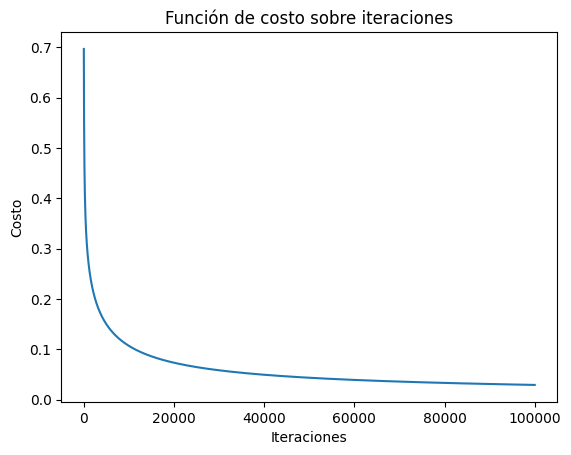

Predictions: [[9.49540416e-01 9.99999999e-01 9.34503400e-02 1.03718824e-04
  3.88603008e-02 6.96932210e-08 1.00000000e+00 9.12937047e-01
  9.90169539e-01 1.30299777e-05]]
Predicted labels: [0 0 0 0 0 0 0 0 0 0]
True labels: [0 0 0 0 0 0 0 0 0 0]
Accuracy: 1.0
Predictions: [[9.49540416e-01 9.99999999e-01 9.34503400e-02 1.03718824e-04
  3.88603008e-02 6.96932210e-08 1.00000000e+00 9.12937047e-01
  9.90169539e-01 1.30299777e-05]]
Predicted labels: [0 0 0 0 0 0 0 0 0 0]
True labels: [0 0 0 0 0 0 0 0 0 0]
Accuracy: 1.0


In [25]:
'Testing accuracy'
np.random.seed(1)
X=np.random.randn(2,10)
Y=np.zeros((1,10))
Y[0:]=(X[0,:]>X[1,:])
parameters=train(X, Y, [2,1], ['Sigmoid'], 'Binary', 0.1, 100000, 100000,True)
Y
np.where(predict(X,parameters,['Sigmoid']) > 0.5, 1, 0)
accuracy (X, Y, parameters,['Sigmoid'])
assert accuracy (X, Y, parameters,['Sigmoid'])==1, "Wrong value"

# ---------------------------------------------------------------------------------------------------------------------

# **Test lineal**


In [ ]:
'Testing train: perceptron lineal'
np.random.seed(1)
X=np.random.randn(3,5)
'X'
X
Y=np.zeros((1,5))
Y.shape
Y[0]=(2.5 * X[0] + 1.5 * X[1] + 0.5 * X[2])
'Y'
Y
Y.shape

parameters=train(X, Y, [3,1], ['Lineal'], 'mse', 0.1, 100000, 10000,False)
predict(X,parameters,['Lineal'])
assert np.all(np.isclose(predict(X,parameters,['Lineal']),Y)), "Wrong values"

'Testing train: perceptron lineal'

'X'

array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
       [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
       [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]])

(1, 5)

'Y'

array([[ 1.33960933,  0.05775626, -2.62344833, -2.39589009,  2.35634823]])

(1, 5)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
             dtype=float128)                                                     ,
       'Lineal'], dtype=object)]
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
              [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
       array([[2.5, 1.5, 0.5]], dtype=float128),
       array([[ 1.33960933,  0.05775626, -2.62344833, -2.39589009,  2.35634823]],
             dtype=float128)                                                     ,
       'Lineal'], dtype=object)]
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
              [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
       array([[2.5, 1.5, 0.5]], dtype=float128),
       array([[ 1.33960933,  

array([[ 1.33960933,  0.05775626, -2.62344833, -2.39589009,  2.35634823]],
      dtype=float128)

'Testing lineal train'

array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
       [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
       [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]])

(1, 5)

array([[ 5.4289447 , 12.55936327, -0.43899375,  3.3675906 ,  2.32443954]])

'Test # 1: Relu-Lineal'

[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
              [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
       array([[-0.01099891, -0.00172428, -0.00877858],
              [ 0.00042214,  0.00582815, -0.01100619]]),
       array([[0.        , 0.02180523, 0.00995222, 0.01462283, 0.        ],
              [0.        , 0.03258509, 0.        , 0.00563344, 0.        ]],
             dtype=float128)                                                ,
       'Relu'], dtype=object), array([array([[0.        , 0.02180523, 0.00995222, 0.01462283, 0.        ],
              [0.        , 0.03258509, 0.        , 0.00563344, 0.        ]],
             dtype=float128)                                                ,
       array([[0.01144724, 0.00901591]]),
       array([[0.        , 0.00054339, 0.00011393, 0.00021818, 0.        ]],
             dtype=float128)  

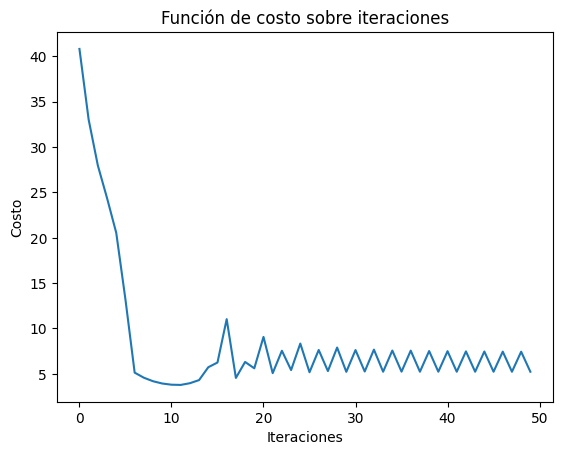

array([[2.70537066, 8.16975338, 2.70537066, 2.70537066, 2.70537066]],
      dtype=float128)

7.431440368099146823

'Test # 2: Sigmoid-Lineal'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
              [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
       array([[ 1.12964747,  3.04158797, -1.51186041],
              [ 1.12815879,  3.02832112, -1.50371677]], dtype=float128),
       array([[3.87127281e-05, 9.92946614e-01, 5.44346392e-03, 7.98446429e-02,
               1.36754523e-02],
              [4.05329313e-05, 9.92711047e-01, 5.52079843e-03, 7.98565643e-02,
               1.39091064e-02]], dtype=float128)                              ,
       'Sigmoid'], dtype=object), array([array([[3.87127281e-05, 9.92946614e-01, 5.44346392e-03, 7.98446429e-02,
               1.36754523e-02],
              [4.05329313e-05, 9.92711047e-01, 5.52079843e-03, 7.98565643e-02,
               1.39091064e-02]], dtype=float128)                 

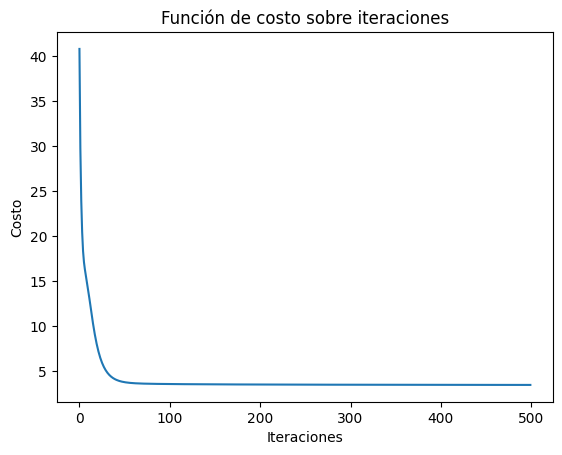

array([[ 2.42767022, 12.55659116,  2.45484867,  3.3074927 ,  2.49442782]],
      dtype=float128)

3.482897580216360562

'Test # 3: Tanh-Lineal'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
       'Lineal'], dtype=object)]
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763],
              [-2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944]]),
       array([[ 114.79730958,   28.99805136,  -86.96225187],
              [ 662.74270043,  168.57143849, -478.27451744]], dtype=float128),
       array([[-0.41498374,  1.        , -1.        , -1.        ,  0.45921051],
              [-0.3095773 ,  1.        , -1.        , -1.        , -0.31638087]],
             dtype=float128)                                                     ,
       'Tanh'], dtype=object), array([array([[-0.41498374,  1.        , -1.        , -1.        ,  0.45921051],
              [-0.3095773 ,  1.        , -1.        , -1.        , -0.31638087]],
             dtype=float128)                                              

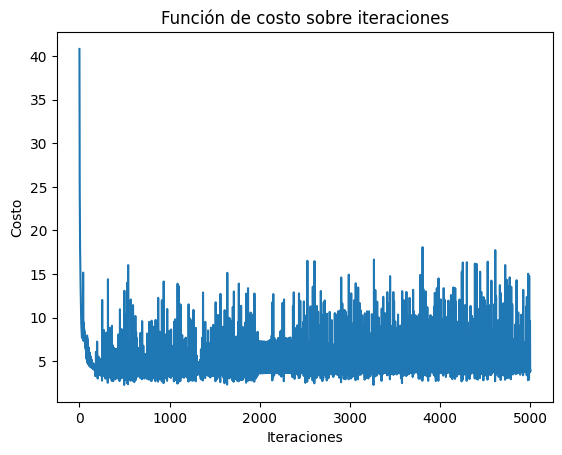

array([[ 5.39048403, 11.71342277,  2.22926574,  2.22926574,  5.46168394]],
      dtype=float128)

3.7949578293780212412

AssertionError: Wrong values

In [ ]:
'Testing lineal train'
np.random.seed(1)
X=np.random.randn(3,5)
X
Y=np.zeros((1,5))
Y.shape
Y[0]=(2.5 * np.power(X[0], 2)  + 1.5 *X[1]  +  0.5 * np.power(X[2],4))
Y
layers=[3,2,1]
activations=['Relu','Lineal']
'Test # 1: '+"-".join(activations)
parameters=train(X, Y, layers, activations, 'mse', 0.1, 50, 10, True)
predict(X,parameters,activations)
mse(X,Y,parameters,activations)
assert math.isclose(mse(X,Y,parameters,activations),7.4314403680991425), "Wrong values"

activations=['Sigmoid','Lineal']
'Test # 2: '+"-".join(activations)
parameters=train(X, Y, layers, activations, 'mse', 0.1, 500, 100, True)
predict(X,parameters,activations)
mse(X,Y,parameters,activations)
#assert math.isclose(mse(X,Y,parameters,activations),4.085368185713057), "Wrong values"
activations=['Tanh','Lineal']

'Test # 3: '+"-".join(activations)
parameters=train(X, Y, layers, activations, 'mse', 0.1,  5000, 1000, True)
predict(X,parameters,activations)
mse(X,Y,parameters,activations)
assert math.isclose(mse(X,Y,parameters,activations),6.857262781783065e-27), "Wrong values"
assert np.all(np.isclose(predict(X,parameters,activations),Y)), "Wrong values"

# ---------------------------------------------------------------------------------------------------------------------

# **Test Multiclass**

'Testing train'

array([[1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 1.]])

Se truncaron las últimas líneas 5000 del resultado de transmisión.
       array([[ 0.41964772, -0.40387915],
              [-0.41964772,  0.40387915]], dtype=float128),
       array([[ 0.56340965,  1.04759744,  0.38084326,  0.17711446,  0.37753224,
               -0.04934057,  1.27411817,  0.50738172,  0.58910652,  0.13223712],
              [ 0.43659035, -0.04759744,  0.61915674,  0.82288554,  0.62246776,
                1.04934057, -0.27411817,  0.49261828,  0.41089348,  0.86776288]],
             dtype=float128)                                                     ,
       'softmax'], dtype=object)]
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
               -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
               -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521]]),
       array([[ 0.41964772, -0.40387915],
              [-0.419647

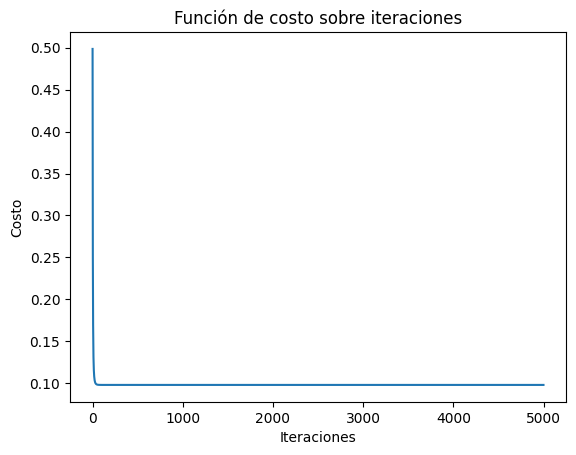

array([[1, 1, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 1]])

In [ ]:
'Testing train'
np.random.seed(1)
X=np.random.randn(2,10)
Y=np.zeros((2,10))
Y[0:]=(X[0,:]>X[1,:])
Y[1:]=(X[0,:]<=X[1,:])
Y
parameters=train(X, Y, [2,2], ['softmax'], 'cathegory', 0.1, 5000, 1000, True)
np.where(predict(X,parameters,['softmax'])> 0.5, 1, 0)
assert np.all(np.isclose(np.where(predict(X,parameters,['softmax'])> 0.5, 1, 0), Y )), "Wrong values"

'Testing multiclass train'

array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
        -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
       [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
        -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521],
       [-1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
        -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547]])

(4, 10)

array([[1., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

'Test # 1: softmax'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
                1.08347360e+00,  8.05271800e-01,  6.54784962e-01,
               -4.52603683e-03],
              [ 2.28427371e-01, -7.93415622e-02,  4.16440490e-01,
                3.47609077e-01,  7.43095407e-01, -7.42178556e-02,
               -5.73782413e-02, -2.36451208e-01,  1.28633552e-01,
                5.83182971e-01],
              [-4.01419873e-01,  9.56810324e-01,  6.68418094e-01,
                7.12757802e-01,  1.89147082e-01,  8.31277963e-01,
               -2.60953539e-02,  4.31179409e-01,  2.16581486e-01,
                4.21343066e-01],
              [-9.10104730e-16,  6.66503068e-14, -2.93735328e-14,
               -4.08637006e-14, -5.66110717e-14, -2.58999982e-14,
                8.21574607e-14,  3.30262485e-14,  1.03040807e-14,
               -6.39723472e-14]], dtype=float128)                ,
       'softmax'], dtype=object)]
[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86

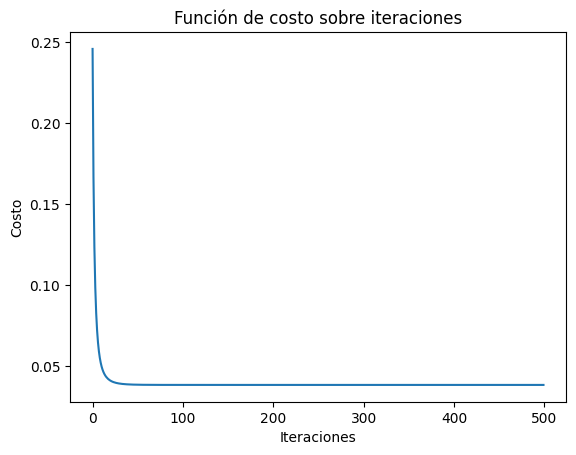

array([[1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

'Test # 2: relu-softmax'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
               -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038],
              [ 1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
               -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521],
              [-1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
               -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547]]),
       array([[-0.18410847,  0.36495582,  0.36251398],
              [-0.40788039,  0.07060355,  0.52648071],
              [ 0.2187051 ,  0.35336045, -0.1010847 ],
              [ 0.0216413 , -0.31089499, -0.16229832]], dtype=float128),
       array([[-0.16484062, -0.22465228,  0.30601227,  0.23914114,  0.58061991,
               -0.22593967, -0.42911257, -0.51986422, -0.14084465,  0.45047444],
              [-1.15288248,  0.69262605,  0.65321813,  0.66096175,  0.18722953,
                0.48700765, -0.80266698, -0.25828

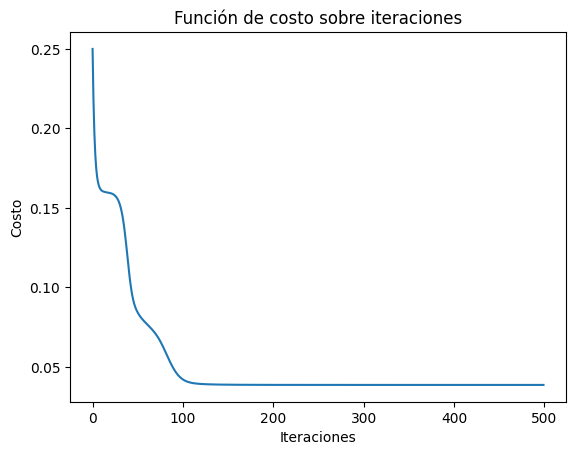

array([[1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
'Testing multiclass train'
np.random.seed(1)
X=np.random.randn(3,10)
X
Y=np.zeros((4,10))
Y.shape
Y[0]=((X[0]>X[1]) & (X[0]>X[2])).astype(int)
Y[1]=((X[1]>X[0]) & (X[1]>X[2])).astype(int)
Y[2]=((X[2]>X[0]) & (X[2]>X[1])).astype(int)
Y[3]=((Y[0]+Y[1]+Y[2])==0)
Y

layers=[3,4]
activations=['softmax']
'Test # 1: '+"-".join(activations)

parameters=train(X, Y, layers, activations, 'cathegory', 0.1, 500, 100,True)
np.where(predict(X,parameters,activations)> 0.8, 1, 0)
assert np.all(np.isclose(np.where(predict(X,parameters,activations)> 0.5, 1, 0), Y )), "Wrong values"

layers=[3,4,4]
activations=['relu','softmax']
'Test # 2: '+"-".join(activations)
parameters=train(X, Y, layers, activations, 'cathegory', 0.1, 500, 100,True)
np.where(predict(X,parameters,activations)> 0.8, 1, 0)
assert np.all(np.isclose(np.where(predict(X,parameters,activations)> 0.5, 1, 0), Y )), "Wrong values"

# ---------------------------------------------------------------------------------------------------------------------

# **Optimization**

'Testing optimization. Mini-batch. Multiclass train'

(4, 1000)

'Test # 1: Relu-Softmax'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
               0.00000000e+00, 7.13763898e-01, 6.51483849e-01, 0.00000000e+00,
               0.00000000e+00, 8.53812161e-01, 6.63603414e-01, 8.26294873e-01,
               0.00000000e+00, 9.85709344e-01, 0.00000000e+00, 0.00000000e+00,
               2.08967267e-02, 3.08185690e+00, 0.00000000e+00, 0.00000000e+00,
               1.41297414e+00, 8.27829147e-01, 3.13380355e+00, 0.00000000e+00,
               7.93157462e-01, 5.32005890e+00, 0.00000000e+00, 0.00000000e+00,
               2.18987139e+00, 0.00000000e+00, 1.21624584e+00, 5.83675439e-01]],
             dtype=float128)                                                    ,
       array([[ 0.13571672,  1.15663386, -0.71257329, -0.95146194],
              [-0.04195799, -0.4925432 , -0.72102413,  1.65921236],
              [-0.06456252, -0.52352807,  1.66883088, -0.47309651],
              [-0.00939432, -0.12986657, -0.20884564, -0.21884133]],
             dtype=floa

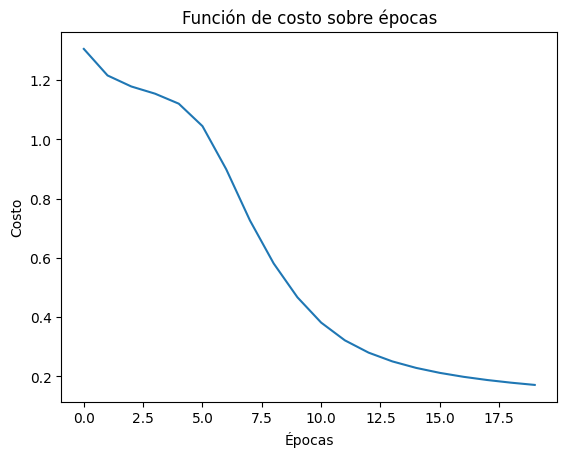

Predictions: [[9.82785032e-01 1.16541693e-02 7.78693234e-03 ... 5.98276229e-01
  2.20919867e-01 6.14806542e-04]
 [8.15871381e-03 6.80565782e-04 9.78125021e-01 ... 3.22001181e-02
  7.60790982e-01 9.98717431e-01]
 [6.75552888e-03 9.87048464e-01 1.21621411e-02 ... 3.59062576e-01
  1.30448195e-02 4.73474696e-04]
 [2.30072567e-03 6.16801077e-04 1.92590541e-03 ... 1.04610768e-02
  5.24433156e-03 1.94287478e-04]]
Predicted labels: [0 2 1 1 0 2 0 1 1 1 0 2 2 1 1 1 2 0 0 0 1 0 0 0 0 1 1 1 0 0 1 2 1 1 2 1 1
 2 0 0 0 2 1 0 0 2 1 0 1 0 0 2 2 0 1 1 2 1 1 0 1 0 2 2 0 1 0 0 0 2 2 2 1 1
 1 2 1 1 0 2 1 2 2 0 1 0 2 2 1 0 1 2 1 1 0 2 1 2 1 0 2 1 2 2 1 2 2 1 2 1 2
 1 0 2 0 2 2 2 0 1 0 1 0 0 2 0 0 0 1 2 2 1 1 0 0 2 2 1 0 1 0 0 0 2 0 1 2 2
 2 0 0 1 0 0 2 1 2 1 1 1 2 2 0 2 1 0 2 0 0 1 2 1 0 1 2 2 0 2 0 2 2 0 0 0 1
 1 0 2 1 0 0 1 0 2 1 1 0 0 0 0 2 0 2 0 1 1 1 2 2 0 1 2 0 0 2 0 2 2 0 0 0 1
 0 1 1 0 2 1 1 1 1 1 1 0 2 2 2 2 1 2 1 2 2 2 1 1 0 1 0 2 2 1 1 0 0 2 0 1 2
 2 2 1 2 1 1 0 2 0 0 1 0 0 0 0 0 2 1 0 1 1 1 2 

0.986

Predictions: [[9.82785032e-01 1.16541693e-02 7.78693234e-03 ... 5.98276229e-01
  2.20919867e-01 6.14806542e-04]
 [8.15871381e-03 6.80565782e-04 9.78125021e-01 ... 3.22001181e-02
  7.60790982e-01 9.98717431e-01]
 [6.75552888e-03 9.87048464e-01 1.21621411e-02 ... 3.59062576e-01
  1.30448195e-02 4.73474696e-04]
 [2.30072567e-03 6.16801077e-04 1.92590541e-03 ... 1.04610768e-02
  5.24433156e-03 1.94287478e-04]]
Predicted labels: [0 2 1 1 0 2 0 1 1 1 0 2 2 1 1 1 2 0 0 0 1 0 0 0 0 1 1 1 0 0 1 2 1 1 2 1 1
 2 0 0 0 2 1 0 0 2 1 0 1 0 0 2 2 0 1 1 2 1 1 0 1 0 2 2 0 1 0 0 0 2 2 2 1 1
 1 2 1 1 0 2 1 2 2 0 1 0 2 2 1 0 1 2 1 1 0 2 1 2 1 0 2 1 2 2 1 2 2 1 2 1 2
 1 0 2 0 2 2 2 0 1 0 1 0 0 2 0 0 0 1 2 2 1 1 0 0 2 2 1 0 1 0 0 0 2 0 1 2 2
 2 0 0 1 0 0 2 1 2 1 1 1 2 2 0 2 1 0 2 0 0 1 2 1 0 1 2 2 0 2 0 2 2 0 0 0 1
 1 0 2 1 0 0 1 0 2 1 1 0 0 0 0 2 0 2 0 1 1 1 2 2 0 1 2 0 0 2 0 2 2 0 0 0 1
 0 1 1 0 2 1 1 1 1 1 1 0 2 2 2 2 1 2 1 2 2 2 1 1 0 1 0 2 2 1 1 0 0 2 0 1 2
 2 2 1 2 1 1 0 2 0 0 1 0 0 0 0 0 2 1 0 1 1 1 2 

AssertionError: Wrong accuracy

In [ ]:
'Testing optimization. Mini-batch. Multiclass train'
np.random.seed(1)
X=np.random.randn(3,1000)
Y=np.zeros((4,1000))
Y.shape
Y[0]=((X[0]>X[1]) & (X[0]>X[2])).astype(int)

Y[1]=((X[1]>X[0]) & (X[1]>X[2])).astype(int)
Y[2]=((X[2]>X[0]) & (X[2]>X[1])).astype(int)
Y[3]=((Y[0]+Y[1]+Y[2])==0)

layers=[3,4,4]
activations=['Relu','Softmax']
'Test # 1: '+"-".join(activations)
parameters=trainO(X, Y, layers, activations, 'Cathegory', [0.1, 0.1, 0] , 64, 20, 10,True)
accuracy(X,Y,parameters,activations)
assert math.isclose(accuracy(X,Y,parameters,activations),0.98675),"Wrong accuracy"

'Testing optimization. Mini-batch. Learning Decay. Multiclass train'

(4, 1000)

'Test # 1: Relu-Softmax'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
                0.        ,  3.73650223,  0.        ,  0.        ,  2.14544274,
                0.74262819,  1.62388756,  1.59752608,  0.        ,  0.        ,
                0.43807489,  2.03115286,  0.06560486,  0.        ,  0.        ,
                0.        ,  0.68440669,  1.44964731,  0.        ,  0.        ,
                4.58757574,  0.        ,  0.37680179,  0.21864944],
              [ 0.        ,  0.03045425,  0.        ,  5.98832515,  0.18518116,
                3.85748374,  0.61596214,  0.3491898 ,  0.        ,  0.        ,
               11.02217492,  0.        ,  6.1382643 ,  3.21842186,  3.20373619,
                0.        ,  3.71136426,  2.89113992,  0.        ,  0.        ,
                3.80371794,  0.96834895,  1.92623004,  4.65642442,  0.        ,
                0.        ,  0.        ,  0.        ,  0.        ,  3.05865703,
                0.        ,  1.79235548,  4.87630061,  5.57465574

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



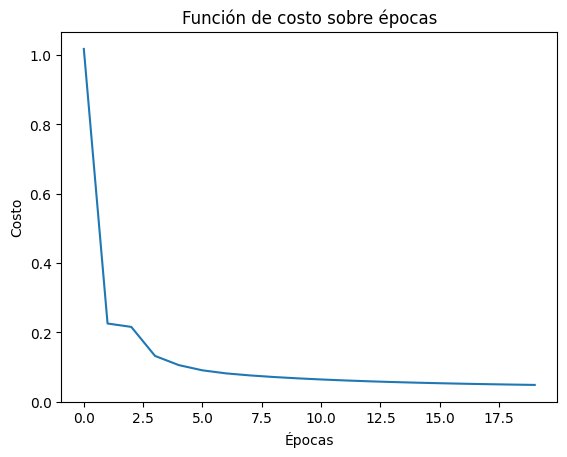

Predictions: [[9.99999999e-01 3.49554535e-09 3.10098307e-08 ... 9.08624486e-01
  7.46817587e-03 2.08784389e-15]
 [2.82377403e-11 1.92792939e-12 9.99999183e-01 ... 8.74364072e-05
  9.92529551e-01 1.00000000e+00]
 [1.13311519e-11 9.99999996e-01 5.46162630e-07 ... 9.10116407e-02
  6.50989311e-08 5.59797156e-13]
 [6.92840126e-10 3.92521339e-10 2.40144902e-07 ... 2.76437184e-04
  2.20819737e-06 1.78180019e-12]]
Predicted labels: [0 2 1 1 0 2 0 1 1 1 0 2 2 1 1 1 2 0 0 0 1 0 0 0 0 1 1 1 0 0 1 2 1 1 2 1 1
 2 0 0 0 2 1 0 0 2 1 0 1 0 0 2 2 0 1 1 2 1 1 0 1 0 2 2 0 1 0 0 0 2 2 2 1 1
 1 2 1 1 0 2 1 2 2 0 1 0 2 2 1 0 1 2 1 1 0 2 1 2 1 0 2 1 2 2 1 2 2 1 2 1 2
 1 0 2 0 2 2 2 0 1 0 1 0 0 2 0 0 0 1 2 2 1 1 0 0 2 2 1 0 1 0 0 0 2 0 1 2 2
 2 0 0 1 0 0 2 1 2 1 1 1 2 2 0 2 1 0 2 0 0 1 2 1 0 1 2 2 0 2 0 2 2 0 0 0 1
 1 0 2 1 0 0 1 0 2 1 1 0 0 0 0 2 0 2 0 1 1 1 2 2 0 1 2 0 0 2 0 2 2 0 0 0 1
 0 1 1 0 2 2 1 1 1 1 1 0 2 2 2 2 1 2 1 2 2 2 1 1 0 1 0 2 2 1 1 0 0 2 0 1 2
 2 2 1 2 1 1 0 2 0 0 1 0 0 0 0 0 2 1 0 1 1 1 2 

0.987

Predictions: [[9.99999999e-01 3.49554535e-09 3.10098307e-08 ... 9.08624486e-01
  7.46817587e-03 2.08784389e-15]
 [2.82377403e-11 1.92792939e-12 9.99999183e-01 ... 8.74364072e-05
  9.92529551e-01 1.00000000e+00]
 [1.13311519e-11 9.99999996e-01 5.46162630e-07 ... 9.10116407e-02
  6.50989311e-08 5.59797156e-13]
 [6.92840126e-10 3.92521339e-10 2.40144902e-07 ... 2.76437184e-04
  2.20819737e-06 1.78180019e-12]]
Predicted labels: [0 2 1 1 0 2 0 1 1 1 0 2 2 1 1 1 2 0 0 0 1 0 0 0 0 1 1 1 0 0 1 2 1 1 2 1 1
 2 0 0 0 2 1 0 0 2 1 0 1 0 0 2 2 0 1 1 2 1 1 0 1 0 2 2 0 1 0 0 0 2 2 2 1 1
 1 2 1 1 0 2 1 2 2 0 1 0 2 2 1 0 1 2 1 1 0 2 1 2 1 0 2 1 2 2 1 2 2 1 2 1 2
 1 0 2 0 2 2 2 0 1 0 1 0 0 2 0 0 0 1 2 2 1 1 0 0 2 2 1 0 1 0 0 0 2 0 1 2 2
 2 0 0 1 0 0 2 1 2 1 1 1 2 2 0 2 1 0 2 0 0 1 2 1 0 1 2 2 0 2 0 2 2 0 0 0 1
 1 0 2 1 0 0 1 0 2 1 1 0 0 0 0 2 0 2 0 1 1 1 2 2 0 1 2 0 0 2 0 2 2 0 0 0 1
 0 1 1 0 2 2 1 1 1 1 1 0 2 2 2 2 1 2 1 2 2 2 1 1 0 1 0 2 2 1 1 0 0 2 0 1 2
 2 2 1 2 1 1 0 2 0 0 1 0 0 0 0 0 2 1 0 1 1 1 2 

AssertionError: Wrong accuracy

In [ ]:
'Testing optimization. Mini-batch. Learning Decay. Multiclass train'
np.random.seed(1)
X=np.random.randn(3,1000)
Y=np.zeros((4,1000))
Y.shape
Y[0]=((X[0]>X[1]) & (X[0]>X[2])).astype(int)
Y[1]=((X[1]>X[0]) & (X[1]>X[2])).astype(int)
Y[2]=((X[2]>X[0]) & (X[2]>X[1])).astype(int)
Y[3]=((Y[0]+Y[1]+Y[2])==0)
layers=[3,4,4]
activations=['Relu','Softmax']
'Test # 1: '+"-".join(activations)
parameters=trainO(X, Y, layers, activations, 'Cathegory', [1, 0.1, 10] , 64, 20, 10,True)
accuracy(X,Y,parameters,activations)
assert math.isclose(accuracy(X,Y,parameters,activations),0.99725),"Wrong accuracy"

'Testing optimization. Mini-batch. Multiclass train'

(4, 1000)

'Test # 1: Relu-Softmax'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
               2.66232720e-01, 7.77273860e-01, 1.75071390e-02, 2.55703941e+00,
               5.82775352e-01, 1.33424789e+00, 8.56978042e-01, 1.05120918e+00,
               5.18548171e-01, 0.00000000e+00, 1.12643308e+00, 0.00000000e+00,
               8.57989046e-02, 2.26037195e-01, 2.20218829e+00, 0.00000000e+00,
               4.22278226e-03, 0.00000000e+00, 0.00000000e+00, 9.13435140e-01]],
             dtype=float128)                                                    ,
       array([[ 5.45278427e-02,  4.41760658e-01, -4.56527356e-01,
               -6.15655836e-01],
              [-8.75275118e-03, -1.80498494e-01, -4.82710992e-01,
                1.09119454e+00],
              [-2.62699007e-02, -2.04935329e-01,  1.10380233e+00,
               -3.13569583e-01],
              [ 2.96702620e-04, -4.56308224e-02, -1.38176155e-01,
               -1.46156538e-01]], dtype=float128)                ,
       array([[0.1235872

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[array([array([[-0.13597733, -0.79726979,  0.28267571, -0.82609743,  0.6210827 ,
                0.9561217 , -0.70584051,  1.19268607, -0.23794194,  1.15528789,
                0.43816635,  1.12232832, -0.9970198 , -0.10679399,  1.45142926,
               -0.61803685, -2.03720123, -1.94258918, -2.50644065, -2.11416392,
               -0.41163916,  1.27852808, -0.44222928,  0.32352735, -0.10999149,
                0.00854895, -0.16819884, -0.17418034,  0.4611641 , -1.17598267,
                1.01012718,  0.92001793, -0.19505734,  0.80539342, -0.70134443,
               -0.53722302,  0.15626385, -0.19022103, -0.44873803, -0.67244804,
               -0.55749472,  0.93916874, -1.94332341,  0.35249436, -0.23643695,
                0.7278135 ,  0.51507361, -2.78253447,  0.58464661,  0.32427424,
                0.02186284, -0.46867382,  0.85328122, -0.41302931,  1.83471763,
                0.56438286,  2.13782807, -0.785534  , -1.75592564,  0.7147896 ,
                0.85270406,  0.0353601 

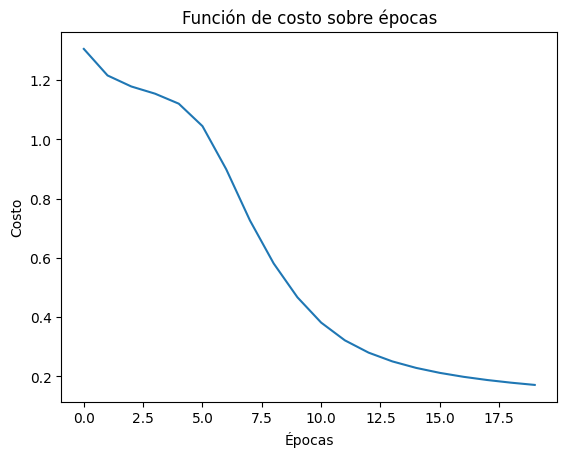

Predictions: [[9.82785032e-01 1.16541693e-02 7.78693234e-03 ... 5.98276229e-01
  2.20919867e-01 6.14806542e-04]
 [8.15871381e-03 6.80565782e-04 9.78125021e-01 ... 3.22001181e-02
  7.60790982e-01 9.98717431e-01]
 [6.75552888e-03 9.87048464e-01 1.21621411e-02 ... 3.59062576e-01
  1.30448195e-02 4.73474696e-04]
 [2.30072567e-03 6.16801077e-04 1.92590541e-03 ... 1.04610768e-02
  5.24433156e-03 1.94287478e-04]]
Predicted labels: [0 2 1 1 0 2 0 1 1 1 0 2 2 1 1 1 2 0 0 0 1 0 0 0 0 1 1 1 0 0 1 2 1 1 2 1 1
 2 0 0 0 2 1 0 0 2 1 0 1 0 0 2 2 0 1 1 2 1 1 0 1 0 2 2 0 1 0 0 0 2 2 2 1 1
 1 2 1 1 0 2 1 2 2 0 1 0 2 2 1 0 1 2 1 1 0 2 1 2 1 0 2 1 2 2 1 2 2 1 2 1 2
 1 0 2 0 2 2 2 0 1 0 1 0 0 2 0 0 0 1 2 2 1 1 0 0 2 2 1 0 1 0 0 0 2 0 1 2 2
 2 0 0 1 0 0 2 1 2 1 1 1 2 2 0 2 1 0 2 0 0 1 2 1 0 1 2 2 0 2 0 2 2 0 0 0 1
 1 0 2 1 0 0 1 0 2 1 1 0 0 0 0 2 0 2 0 1 1 1 2 2 0 1 2 0 0 2 0 2 2 0 0 0 1
 0 1 1 0 2 1 1 1 1 1 1 0 2 2 2 2 1 2 1 2 2 2 1 1 0 1 0 2 2 1 1 0 0 2 0 1 2
 2 2 1 2 1 1 0 2 0 0 1 0 0 0 0 0 2 1 0 1 1 1 2 

0.986

In [ ]:
'Testing optimization. Mini-batch. Multiclass train'
np.random.seed(1)
X = np.random.randn(3, 1000)
Y = np.zeros((4, 1000))
Y.shape
Y[0] = ((X[0] > X[1]) & (X[0] > X[2])).astype(int)

Y[1] = ((X[1] > X[0]) & (X[1] > X[2])).astype(int)
Y[2] = ((X[2] > X[0]) & (X[2] > X[1])).astype(int)
Y[3] = ((Y[0] + Y[1] + Y[2]) == 0)

layers = [3, 4, 4]
activations = ['Relu', 'Softmax']
'Test # 1: ' + "-".join(activations)
parameters = trainO(X, Y, layers, activations, 'Cathegory', [0.1, 0.1, 0], 64, 20, 10, True)
accuracy(X, Y, parameters, activations)
# assert math.isclose(accuracy(X,Y,parameters,activations),0.98675),"Wrong accuracy"

'Testing optimization. Mini-batch. Learning Decay. Multiclass train'

(4, 1000)

'Test # 1: Relu-Softmax'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
               0.00000000e+00, 0.00000000e+00, 5.11159834e+00, 8.41290105e+00,
               0.00000000e+00, 0.00000000e+00, 3.67603777e-01, 6.56695092e-01,
               2.17590307e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 4.01022936e+00, 7.20116667e+00, 1.87848285e+00,
               0.00000000e+00, 0.00000000e+00, 6.44982053e+00, 5.48709255e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.06095339e-01,
               0.00000000e+00, 8.14274627e-01, 5.06320601e+00, 0.00000000e+00,
               1.27651232e+00, 7.63267578e+00, 4.90886130e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.38871054e-01,
               1.10367406e+00, 3.68300265e+00, 1.84302590e+00, 1.72183988e+00,
               4.90830433e+00, 8.51839412e-01, 2.99523826e-01, 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[array([array([[-3.84832249e-01,  1.45810824e+00, -5.32234021e-01,
                1.11813340e+00,  6.74396105e-01, -7.22391905e-01,
                1.09899633e+00, -9.01634490e-01, -8.22467189e-01,
                7.21711292e-01, -6.25342001e-01, -5.93843067e-01,
               -3.43900709e-01, -1.00016919e+00,  1.04499441e+00,
                6.08514698e-01, -6.93286967e-02, -1.08392067e-01,
                4.50155513e-01,  1.76533510e+00,  8.70969803e-01,
               -5.08457134e-01,  7.77419205e-01, -1.18771172e-01,
               -1.98998184e-01,  1.86647138e+00, -4.18937898e-01,
               -4.79184915e-01, -1.95210529e+00, -1.40232915e+00,
                4.51122939e-01, -6.94920901e-01,  5.15413802e-01,
               -1.11487105e+00, -7.67309826e-01,  6.74570707e-01,
                1.46089238e+00,  5.92472801e-01,  1.19783084e+00,
                1.70459417e+00,  1.04008915e+00, -9.18440038e-01,
               -1.05344713e-01,  6.30195671e-01, -4.14846901e-01,
         

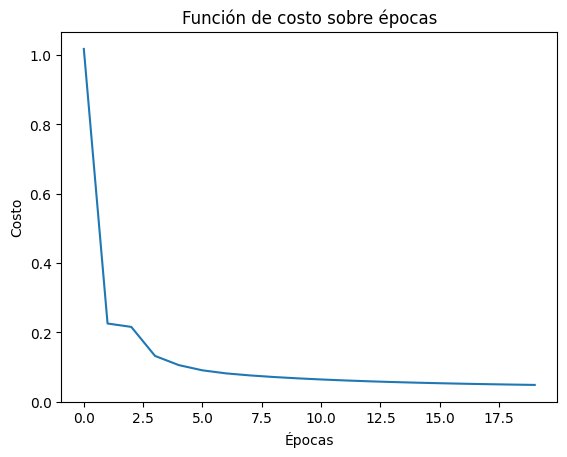

Predictions: [[9.99999999e-01 3.49554535e-09 3.10098307e-08 ... 9.08624486e-01
  7.46817587e-03 2.08784389e-15]
 [2.82377403e-11 1.92792939e-12 9.99999183e-01 ... 8.74364072e-05
  9.92529551e-01 1.00000000e+00]
 [1.13311519e-11 9.99999996e-01 5.46162630e-07 ... 9.10116407e-02
  6.50989311e-08 5.59797156e-13]
 [6.92840126e-10 3.92521339e-10 2.40144902e-07 ... 2.76437184e-04
  2.20819737e-06 1.78180019e-12]]
Predicted labels: [0 2 1 1 0 2 0 1 1 1 0 2 2 1 1 1 2 0 0 0 1 0 0 0 0 1 1 1 0 0 1 2 1 1 2 1 1
 2 0 0 0 2 1 0 0 2 1 0 1 0 0 2 2 0 1 1 2 1 1 0 1 0 2 2 0 1 0 0 0 2 2 2 1 1
 1 2 1 1 0 2 1 2 2 0 1 0 2 2 1 0 1 2 1 1 0 2 1 2 1 0 2 1 2 2 1 2 2 1 2 1 2
 1 0 2 0 2 2 2 0 1 0 1 0 0 2 0 0 0 1 2 2 1 1 0 0 2 2 1 0 1 0 0 0 2 0 1 2 2
 2 0 0 1 0 0 2 1 2 1 1 1 2 2 0 2 1 0 2 0 0 1 2 1 0 1 2 2 0 2 0 2 2 0 0 0 1
 1 0 2 1 0 0 1 0 2 1 1 0 0 0 0 2 0 2 0 1 1 1 2 2 0 1 2 0 0 2 0 2 2 0 0 0 1
 0 1 1 0 2 2 1 1 1 1 1 0 2 2 2 2 1 2 1 2 2 2 1 1 0 1 0 2 2 1 1 0 0 2 0 1 2
 2 2 1 2 1 1 0 2 0 0 1 0 0 0 0 0 2 1 0 1 1 1 2 

0.987

In [ ]:
'Testing optimization. Mini-batch. Learning Decay. Multiclass train'
np.random.seed(1)
X = np.random.randn(3, 1000)
Y = np.zeros((4, 1000))
Y.shape
Y[0] = ((X[0] > X[1]) & (X[0] > X[2])).astype(int)
Y[1] = ((X[1] > X[0]) & (X[1] > X[2])).astype(int)
Y[2] = ((X[2] > X[0]) & (X[2] > X[1])).astype(int)
Y[3] = ((Y[0] + Y[1] + Y[2]) == 0)
layers = [3, 4, 4]
activations = ['Relu', 'Softmax']
'Test # 1: ' + "-".join(activations)
parameters = trainO(X, Y, layers, activations, 'Cathegory', [1, 0.1, 10], 64, 20, 10, True)
accuracy(X, Y, parameters, activations)
# assert math.isclose(accuracy(X,Y,parameters,activations),0.99725),"Wrong accuracy"

# ---------------------------------------------------------------------------------------------------------------------

# **Regularization** :(


'Testing regularization. Early_Stoping'

(4, 1000)

array([204., 376., 133., 287.])

'Test # 1: relu-softmax'

[array([array([[ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
               -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
                1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
               -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521,
               -1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
               -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547,
               -0.69166075, -0.39675353, -0.6871727 , -0.84520564, -0.67124613,
               -0.0126646 , -1.11731035,  0.2344157 ,  1.65980218,  0.74204416,
               -0.19183555, -0.88762896, -0.74715829,  1.6924546 ,  0.05080775,
               -0.63699565,  0.19091548,  2.10025514,  0.12015895,  0.61720311,
                0.30017032, -0.35224985, -1.1425182 , -0.34934272, -0.20889423,
                0.58662319,  0.83898341,  0.93110208,  0.28558733,  0.88514116,
               -0.75439794,  1.25286816

<ipython-input-23-83816f8cba6e>:107: RuntimeWarning: overflow encountered in square
  cost = np.mean(np.square(Yp - Y))


Se truncaron las últimas líneas 5000 del resultado de transmisión.
              [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
              [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
              [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
               nan, nan, nan, nan, nan, nan, nan, nan, nan, n

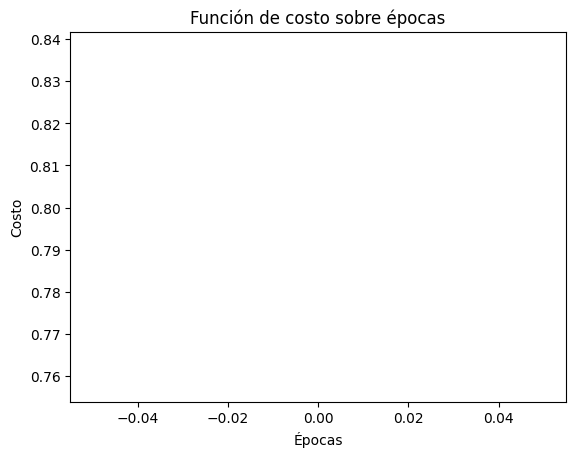

Accuracy: 0.75


0.75

Accuracy: 0.75


AssertionError: Wrong accuracy training

In [ ]:
'Testing regularization. Early_Stoping'
np.random.seed(1)
X=np.random.randn(3,1000)
Y=np.zeros((4,1000))
Y[0]=((X[0]*X[0]+X[1]*X[1]+X[2]*X[2])<=1).astype(int)
Y[1]= (Y[0]!=1) & ((X[0]*X[0]*X[0]+X[1]*X[1]+X[2]*X[2])<=2).astype(int)
Y[2]= (Y[0]!=1) & (Y[1]!=1) & (X[0]*X[0]*X[0]+X[1]*X[1]+X[2]*X[2]<=3).astype(int)
Y[3]= ((Y[0]+Y[1]+Y[2])==0)
Y.shape
np.sum(Y,axis=1)
layers=[3,4,4]
activations=['relu','softmax']
'Test # 1: '+"-".join(activations)
parameters=trainO(X, Y, layers, activations, 'cathegory', [1, 0.1, 100] , 64, 2000, 1000,True)
accuracy(X,Y,parameters,activations)
assert math.isclose(accuracy(X,Y,parameters,activations),0.931),"Wrong accuracy training"

In [ ]:
np.random.seed(1)
X_t=np.random.randn(3,100)
Y_t=np.zeros((4,100))
Y_t[0]=((X_t[0]*X_t[0]+X_t[1]*X_t[1]+X_t[2]*X_t[2]+X_t[1])<=1).astype(int)
Y_t[1]= (Y_t[0]!=1) & ((X_t[0]*X_t[0]+X_t[1]*X_t[1]+X_t[2]*X_t[2])<=2).astype(int)
Y_t[2]= (Y_t[0]!=1) & (Y_t[1]!=1) & (X_t[0]*X_t[0]+X_t[1]*X_t[1]+X_t[2]*X_t[2]<=3).astype(int)
Y_t[3]= ((Y_t[0]+Y_t[1]+Y_t[2])==0)
Y_t.shape
np.sum(Y_t,axis=1)
accuracy(X_t,Y_t,parameters,activations)
assert math.isclose(accuracy(X_t,Y_t,parameters,activations),0.82),"Wrong accuracy testing"

(4, 100)

array([23., 24., 20., 33.])

Accuracy: 0.75


0.75

Accuracy: 0.75


AssertionError: Wrong accuracy testing

# ---------------------------------------------------------------------------------------------------------------------

# **Respuesta a Preguntas**

**PARTE B. S-RNN-IAAP. Segunda extensión.**
- **¿Qué problema nos permite resolver?**
  
  Nos permite resolver problemas para el entrenamiento de redes neuronales de aprendizaje supervisado.
   
- **¿Cómo?**

  Lo hace por medio de la inicialización de parámetros, por iteraciones con épocas y mini lotes. A parte implementa los algoritmos de propagación hacia adelante y hacia atrás para calcular las predicciones y los gradientes de los parámetros con respecto a la función de costo. También actualiza los parámetros con el uso de los gradientes, junto con el learning rate que se va ajustando en cada época. Registra los costos promedios por épocas para mantener bajo vigilancia el proceso de entrenamiento, aplicando, nuevamente, el decaimiento del learning rate.


**PARTE C. S-RNN-IAAP. Tercera extensión.**
- *¿Qué problema nos permite resolver?*
- *¿Cómo?*

# ---------------------------------------------------------------------------------------------------------------------

# **Keras**

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from platform import python_version
'Python ' + python_version()
import numpy as np
import pandas as pd
#Keras
irisData = pd.read_fwf("/content/sample_data/iris.data")

# División de la única columna en varias columnas
irisData[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']] = irisData['5.1,3.5,1.4,0.2,Iris-setosa'].str.split(',', expand=True)

# Eliminación de la columna original
irisData.drop(columns=['5.1,3.5,1.4,0.2,Iris-setosa'], inplace=True)

irisData = irisData.dropna()
irisData = irisData.drop_duplicates()

irisData.info()

irisData.head()

'Python 3.10.12'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 148
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sepal_length  146 non-null    object
 1   sepal_width   146 non-null    object
 2   petal_length  146 non-null    object
 3   petal_width   146 non-null    object
 4   class         146 non-null    object
dtypes: object(5)
memory usage: 6.8+ KB


sepal_length sepal_width petal_length petal_width        class
0          4.9         3.0          1.4         0.2  Iris-setosa
1          4.7         3.2          1.3         0.2  Iris-setosa
2          4.6         3.1          1.5         0.2  Iris-setosa
3          5.0         3.6          1.4         0.2  Iris-setosa
4          5.4         3.9          1.7         0.4  Iris-setosa

In [ ]:
!pip install pandas
!pip install tensorflow keras sklearn

import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split

model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(4,activation='relu'))
model.add(Dense(3,activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Dense(3,activation='relu'))
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

X = irisData[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

irisData['class'] = pd.Categorical(irisData['class']).codes

y = irisData['class']

X_retain, X_holdout, y_retain, y_holdout = train_test_split(X,y,test_size=0.2,random_state=1)

X_retain.shape
y_retain.shape

# Convert the string values in X_retain to float
X_retain = X_retain.astype(np.float32)

# Convert the string values in y_retain to float
y_retain = y_retain.astype(np.float32)

X_holdout = X_holdout.astype(np.float32)

y_holdout = y_holdout.astype(np.float32)

model.fit(
    x=X_retain,
    y=y_retain,
    batch_size=2,
    epochs=100,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=False,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)

loss, accuracy = model.evaluate(x=X_holdout,y=y_holdout,batch_size=200)
print(f"Test accuracy on hold out set is: {accuracy:0.4f}")

(116, 4)

(116,)

Epoch 1/100
58/58 [==============================] - 1s 5ms/step - loss: -0.1111 - accuracy: 0.3362
Epoch 2/100
58/58 [==============================] - 0s 4ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 3/100
58/58 [==============================] - 0s 3ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 4/100
58/58 [==============================] - 0s 3ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 5/100
58/58 [==============================] - 0s 5ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 7/100
58/58 [==============================] - 0s 5ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 8/100
58/58 [==============================] - 0s 5ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 9/100
58/58 [==============================] - 0s 4ms/step - loss: -0.1315 - accuracy: 0.3362
Epoch 10/100
58/58 [==============================] - 0s 5ms/step - loss: -0.1315 - accuracy: 0.3362

# ---------------------------------------------------------------------------------------------------------------------

# **Retrospectiva**
**1. ¿Cuál fue el tiempo total invertido en el laboratorio por cada uno de ustedes? (Horas/Nombre)**

- Juan Pablo: 90 horas
- Juan Sebastian:

**2. ¿Cuál es el estado actual del laboratorio? ¿Por qué?**

Incompleto, faltaron que algunas pruebas pasaran, optimización falto pulir, y regularización quedó a medias. A parte, faltaron puntos como los de aplicación y desarrollo. Esto se dió porque habían conceptos que nos costaron entender y que nos tomó demasiado tiempo llegar a implementar.

**3. ¿Cuál consideran fue el mayor logro? ¿Por qué?**

Nuestro mayor logro fue llegar a comprender y aprovechar una red neuronal profunda, desde su etapa de creación, desarrollo y entrenamiento, hasta los términos de optimización y regularización.

**4. ¿Cuál consideran que fue el mayor problema técnico? ¿Qué hicieron para resolverlo?**

El mayor problema técnico fue la comprensión de los nuevos conceptos integrados este semestre. Aún cuesta entender algunos, pero cuando teníamos un problema, acudiamos a las diapositivas, el libro o hacíamos investigaciones.

**5. ¿Qué hicieron bien como equipo? ¿Qué se comprometen a hacer para mejorar los resultados?**

Como equipo realizamos bien la ejecución de tareas. Cada uno tenía su respectivo trabajo en el laboratorio, el cual la mayoría se cumplió. Aún asi, nos hizo falta conocimientos y tiempo, debido a que este laboratorio era demasiado extenso, y el tiempo nos jugó en contra.

# ---------------------------------------------------------------------------------------------------------------------